In [1]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.appName("heySpark").getOrCreate()
spark

25/03/18 02:56:41 WARN Utils: Your hostname, dmtr-t14 resolves to a loopback address: 127.0.1.1; using 192.168.178.10 instead (on interface wlp3s0)
25/03/18 02:56:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/18 02:56:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/18 02:56:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
socketDF = spark.readStream.format("socket").option("host", "localhost").option("port", 9999).load()

25/03/18 02:57:05 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


In [4]:
socketDF.isStreaming

True

In [5]:
streamWriterMem = socketDF.writeStream.outputMode("append").format("memory")

In [9]:
memoryQuery = streamWriterMem.queryName("memoryDF").start()
memoryQuery.awaitTermination(10)
memoryQuery.stop()

25/03/18 03:00:01 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-f26e3bf6-4c7e-4275-878a-1dca48cfaa9c. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/03/18 03:00:01 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [10]:
spark.sql("SELECT * FROM memoryDF LIMIT 10").show()

+--------------------+
|               value|
+--------------------+
|Bronze Hatchet wa...|
|Iron Two-handed s...|
|Rune Spear was so...|
|Bronze Spear was ...|
|White Spear was s...|
|Rune Hatchet was ...|
|White Hatchet was...|
|Black Hatchet was...|
|Dragon Battleaxe ...|
|Rune Claw was sol...|
+--------------------+



In [11]:
spark.sql("select count(*) from memoryDF").show()

+--------+
|count(1)|
+--------+
|     976|
+--------+



In [17]:
runeregex = "\"^([A-Z].+) ([A-Z].+) was sold for (\\\\d+)\""
q = f"select regexp_extract(value, %s, 1) as material, regexp_extract(value, %s, 2) as tpe, cast(regexp_extract(value, %s, 3) as Integer) as price from memoryDF" % (runeregex, runeregex, runeregex)
spark.sql(q).show(10, 0)

+--------+----------------+------+
|material|tpe             |price |
+--------+----------------+------+
|Bronze  |Hatchet         |774   |
|Iron    |Two-handed sword|5328  |
|Rune    |Spear           |13390 |
|Bronze  |Spear           |1214  |
|White   |Spear           |3311  |
|Rune    |Hatchet         |8832  |
|White   |Hatchet         |2228  |
|Black   |Hatchet         |3430  |
|Dragon  |Battleaxe       |112350|
|Rune    |Claw            |11676 |
+--------+----------------+------+
only showing top 10 rows



# Continuous Stream Processing

In [18]:
consoleQuery = socketDF.writeStream.outputMode("append").format("console").start()

25/03/18 03:12:06 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-66ff6f8f-f145-4bca-9513-7b14a6265867. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/03/18 03:12:06 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+-----+
|value|
+-----+
+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+--------------------+
|               value|
+--------------------+
|White Battleaxe w...|
|Mithril Spear was...|
|Bronze Hatchet wa...|
|Black Halberd was...|
|Bronze Hatchet wa...|
|White Two-handed ...|
|White Claw was so...|
|Dragon Longsword ...|
|Mithril Hatchet w...|
|Bronze Battleaxe ...|
|White Scimitar wa...|
|Bronze Longsword ...|
|Mithril Sword was...|
+--------------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+--------------------+
|               value|
+--------------------+
|White Sword was s...|
|Rune Halberd was ...|
|Black Battleaxe w...|
|Mithril Sword was...|
|Dragon Battleaxe ...|
|Dragon Dagger was...|
|Steel Warhammer w...|
|Black Two-handed ...|
+--------------------+

-------

stop when you've collected enough data :)

In [19]:
consoleQuery.stop()

## Structured console output
Apply previous code to parse the input stream into RuneData

In [20]:
socketDF.createOrReplaceTempView("runeUpdatesDF")

In [41]:
runeregex = "\"^([A-Z].+) ([A-Z].+) was sold for (\\\\d+)\""
q = f"select regexp_extract(value, %s, 1) as material, regexp_extract(value, %s, 2) as type, cast(regexp_extract(value, %s, 3) as Integer) as price from runeUpdatesDF" % (runeregex, runeregex, runeregex)
runes = spark.sql(q)

In [42]:
rConsoleQuery = runes.writeStream.outputMode("append").format("console").start()

25/03/18 03:25:55 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-2122b237-4375-4883-bc71-7f7aa065d713. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/03/18 03:25:55 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+--------+----+-----+
|material|type|price|
+--------+----+-----+
+--------+----+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+--------+---------+-----+
|material|     type|price|
+--------+---------+-----+
|   Steel|    Spear| 1696|
|    Rune|  Hatchet| 8805|
|    Iron|Battleaxe| 4812|
|    Iron|    Spear| 2681|
| Adamant|    Sword| 2656|
|   Black|Battleaxe| 9001|
|  Bronze|Warhammer| 1973|
|   Steel|Battleaxe| 3061|
+--------+---------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+--------+---------+-----+
|material|     type|price|
+--------+---------+-----+
|  Bronze|    Hasta|  631|
|   White| Scimitar| 3373|
|   Steel|  Hatchet| 1066|
|   White|Longsword| 3355|
|    Iron|    Spear| 2692|
|  Bronze|  Halberd| 2982|
|   Black|    Sword| 2076|
|    Rune|Longsword|13015

In [43]:
rConsoleQuery.stop()

In [44]:
streamWriterDisk = runes.writeStream.outputMode("append").option("checkpointLocation", "data/chkpoint").trigger(processingTime="2 seconds")

In [ ]:
stream2disk = streamWriterDisk.start("data/runedata")

25/03/18 03:26:11 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/03/18 03:26:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
25/03/18 03:26:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
25/03/18 03:26:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
25/03/18 03:26:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
25/03/18 03:26:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
25/03/18 03:26:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
25/03/18 03:26:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

In [46]:
stream2disk.stop()

In [47]:
runes = spark.read.parquet("data/runedata/part-*").createOrReplaceTempView("runes")


In [48]:
spark.sql("select material, avg(price) FROM runes GROUP BY material").show()

+--------+------------------+
|material|        avg(price)|
+--------+------------------+
|   Steel|1807.7777777777778|
| Mithril|4984.7959183673465|
|    Rune|           12713.4|
|    Iron| 3133.431818181818|
| Adamant| 5931.510638297872|
|  Dragon|          71669.24|
|   White| 3546.418181818182|
|   Black| 5275.909090909091|
|  Bronze|1638.6315789473683|
+--------+------------------+



In [49]:
spark.sql("select * from runes")

DataFrame[material: string, type: string, price: int]

In [50]:
spark.sql("select material, min(price), max(price) from runes group by material").show()

+--------+----------+----------+
|material|min(price)|max(price)|
+--------+----------+----------+
|   Steel|       552|      4430|
| Mithril|      1467|     10755|
|    Rune|      4152|     33566|
|    Iron|       819|      6894|
| Adamant|      1990|     15059|
|  Dragon|     20834|    161184|
|   White|      1119|      8636|
|   Black|      1591|     12824|
|  Bronze|       372|      3046|
+--------+----------+----------+



In [52]:
spark.sql("select type, count(*) from runes group by type").show()

+----------------+--------+
|            type|count(1)|
+----------------+--------+
|           Sword|      36|
|           Hasta|      40|
|Two-handed sword|      26|
|         Hatchet|      34|
|          Dagger|      27|
|         Halberd|      33|
|       Warhammer|      39|
|           Spear|      20|
|       Longsword|      31|
|            Mace|      29|
|            Claw|      30|
|       Battleaxe|      34|
|        Scimitar|      44|
+----------------+--------+



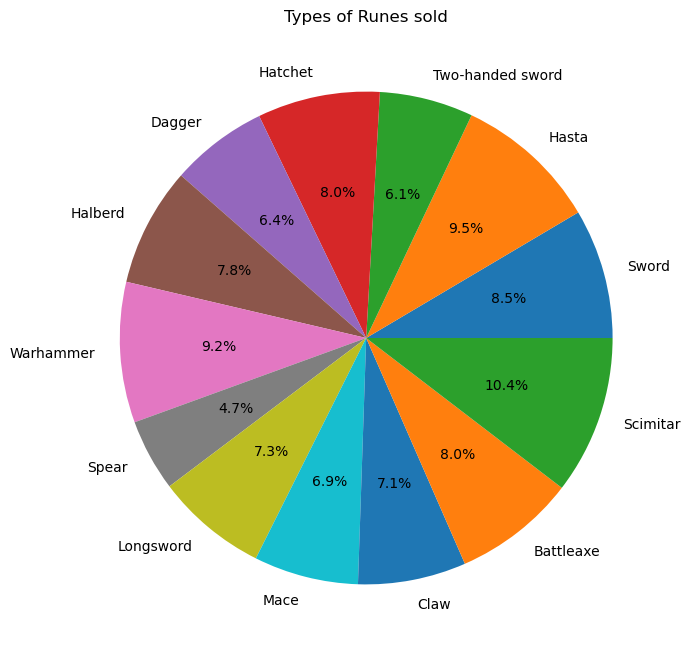

In [93]:
import matplotlib.pyplot as plt
df = spark.sql("select count(*) as count, type from runes group by type").toPandas()
plt.figure(figsize=(8,8))
plt.pie(df["count"], labels=df["type"], autopct="%1.1f%%")
plt.title("Types of Runes sold")
plt.show()

In [57]:
spark.sql("select sum(price) as sum from runes where lower(type) like '%%sword%'").show()

+------+
|   sum|
+------+
|886023|
+------+

